# Label Data
- Take in screenshots of game
- Grab balls and save crops of individual balls
- User input for labeling and grouping ball types into their own folders

In [2]:
import project
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.stats import norm
from pathlib import Path

constants = json.load(open('constants.json'))
print(constants.keys())

dict_keys(['playable_area', 'pockets'])


In [3]:
screenshots_dir = Path('./screenshots')
labeling_dir = Path('./labeling')
if not labeling_dir.exists():
    labeling_dir.mkdir()
unlabeled_dir = Path('./labeling/unlabeled')
if not unlabeled_dir.exists():
    unlabeled_dir.mkdir()

In [ ]:
# take images from screenshots directory -> crop individual balls

show_outputs = False  # for debugging, turn off when actually cropping and getting data
screenshots = sorted(screenshots_dir.glob('screenshot_*.png'))

# get highest numbered unlabeled ball to count upward
file_counter = 0
unlabeled_balls = sorted(unlabeled_dir.glob('ball_*.png'))
if len(unlabeled_balls) > 0:
    unlabeled_balls = [int(str(ball).split('_')[1].split('.')[0]) for ball in unlabeled_balls]
    file_counter = max(unlabeled_balls)


total_balls = 0
for ss_num, screenshot in enumerate(screenshots):
    if ss_num % 10 == 0:
        print(f'Processing screenshot {ss_num} of {len(screenshots)}')
    img = cv2.imread(str(screenshot))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # crop image to playable area
    img = img[constants['playable_area']['top_left'][1]:constants['playable_area']['bottom_right'][1],
              constants['playable_area']['top_left'][0]:constants['playable_area']['bottom_right'][0]]
    # crop image by another 5px on each side
    img = img[15:-15, 15:-15]
    # show image
    circles, data = project.generate_data(img, use_blue=False, k_1=2.5, k_2=1.5,
                                 min_dist=20, canny=100, accum=18, min_radius=23, max_radius=27)
    circles = circles[0]
    # save all individual balls to unlabeled directory
    for i, ball in enumerate(data):
        # save ball image
        file_counter += 1
        filename = unlabeled_dir / f'ball_{file_counter}.png'
        # write bgr
        ball = cv2.cvtColor(ball, cv2.COLOR_RGB2BGR)
        # save
        cv2.imwrite(str(filename), ball)
        # draw circles on img (circles is list of (x, y, r))
    
    total_balls += len(data)
    
    if show_outputs:
        print(f'Processed {screenshot} and saved {len(data)} balls to {unlabeled_dir}')
        for (x, y, r) in circles:
            cv2.circle(img, (x, y), 25, (255, 0, 0), 3)
        
        # show img
        plt.figure(figsize=(12,10))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
        # show all balls
        n_plots = len(data)
        fig, axes = plt.subplots(1, n_plots, figsize=(6,6))
        for i in range(n_plots):
            axes[i].imshow(data[i])
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()

print(f'Processed {len(screenshots)} screenshots and saved {total_balls} balls to {unlabeled_dir}')

NameError: name 'screenshots_dir' is not defined

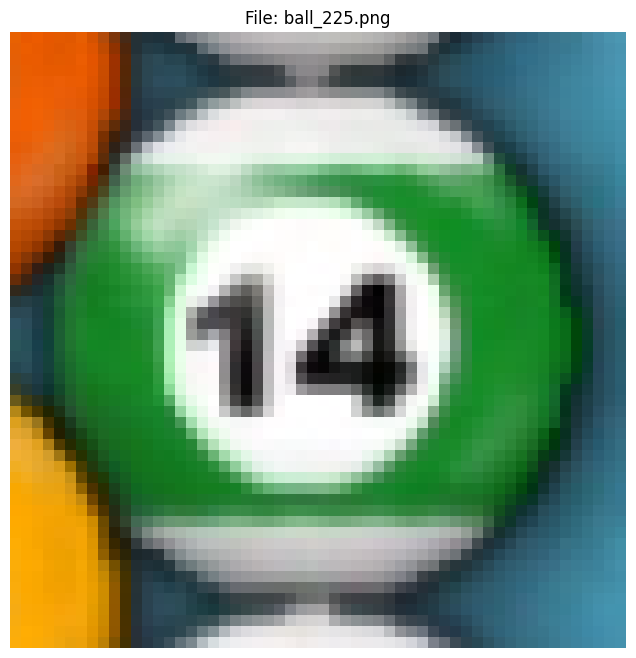

Label this image:
[1] Stripe   [2] Solid   [3] Cue   [4] Eight-ball   [5] Bad    [6] Cancel
Labeling canceled.
Made it up to ball_225.png, set this as the last labeled image.

Images done processing!


In [ ]:
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

label_map = {
    '1': 'stripe',
    '2': 'solid',
    '3': 'cue',
    '4': 'eight-ball',
    '5': 'bad',
}

output_paths = {label: labeling_dir / label for label in label_map.values()}

# Create output directories if they don't exist
for path in output_paths.values():
    path.mkdir(parents=True, exist_ok=True)

# Initialize counters for each label
counters = {label: len(list(output_paths[label].glob('*.png'))) + 1 for label in label_map.values()}

path_name_alr_labeled = 'ball_225.png'


# Process all images in the unlabeled directory
for img_path in sorted(unlabeled_dir.glob('*.*')):  # Match any image extension
    # skip if already labeled
    if path_name_alr_labeled is not None and img_path.name <= path_name_alr_labeled:
        continue

    try:
        # Clear previous outputs
        clear_output(wait=True)
        
        # Display the image
        img = Image.open(img_path)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'File: {img_path.name}')
        display(plt.gcf())
        plt.close()
        
        # Show labeling options
        print("Label this image:")
        print("[1] Stripe   [2] Solid   [3] Cue   [4] Eight-ball   [5] Bad    [6] Cancel")
        
        # Get the label input
        label_input = input("[1] Stripe   [2] Solid   [3] Cue   [4] Eight-ball   [5] Bad    [6] Cancel").strip()

        if label_input == '6':
            print("Labeling canceled.")
            print(f'Made it up to {img_path.name}, set this as the last labeled image.')
            break

        while label_input not in label_map:
            print("Invalid input. Please enter a number from 1 to 5.")
            label_input = input("Enter 1–5: ").strip()
        if label_input == '6':
            print("Labeling canceled.")
            print(f'Made it up to {img_path.name}')
            quit()
        
        label = label_map[label_input]
        
        # Move and rename the file
        count = counters[label]
        new_filename = f"{label}{count}.png"
        shutil.move(str(img_path), str(output_paths[label] / new_filename))
        counters[label] += 1
        
        print(f"Labeled as {label}, saved as {new_filename}")
        
    except Exception as e:
        print(f"Error processing {img_path.name}: {e}")

print("\nImages done processing!")